## Lab 4: Single and Multivariate Linear Regression

In [1]:
# optionally install seaborn if not already installed
!python -m pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Single Variate Linear Regression

This example shows how to compute and plot the optimal solution for single variale linear regression via gradient descent. We will use a subset of the Boston Housing dataset to showcase the model.

*First, we will load the dataset.*

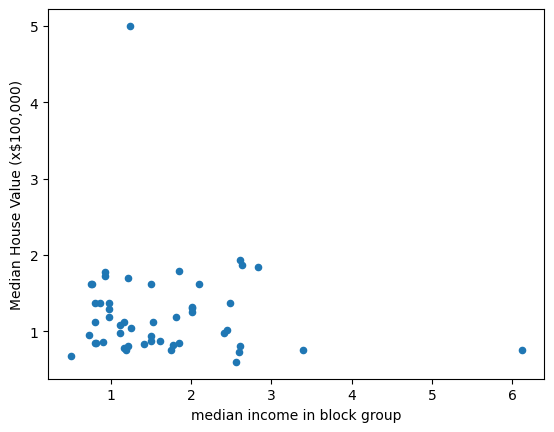

In [2]:
from sklearn.datasets import fetch_california_housing
hd = fetch_california_housing()
housing = pd.DataFrame(hd.data, columns=hd.feature_names)
housing['target'] = hd.target
housing.iloc[50:100,:].plot.scatter(x='MedInc', y='target')
plt.xlabel('median income in block group')
plt.ylabel('Median House Value (x$100,000)')
plt.show()
# housing

In [4]:
print(hd.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


To make things easier to visualize, we're only going to pick 50 samples from the dataset. Also, to ensure proper model training, we will normalize the features (not including the target) using L-inf (max) normalization.

In [4]:
# extract 50 rows
data = housing.loc[51:100].to_numpy()
# normalize the data except for the target
data[:, :-1] = data[:, :-1] / data[:, :-1].max(axis=0)

For the first examples, we're going to pick one of the variables, `MedInc`, and predict the response, `target`, from its values. 

In [5]:
x = data[:,0]
y = data[:,-1]
x, y, x.shape

(array([0.24590164, 0.1815537 , 0.20389651, 0.2631123 , 0.23066865,
        0.24609777, 0.13356651, 0.19892781, 0.41882549, 0.55454947,
        1.        , 0.14727947, 0.19466192, 0.42394129, 0.19069022,
        0.13167056, 0.42649102, 0.30263308, 0.1602079 , 0.28960659,
        0.11908537, 0.28602716, 0.0817057 , 0.40583169, 0.15103869,
        0.39984963, 0.18160273, 0.13118023, 0.32875145, 0.24516614,
        0.19069022, 0.24856578, 0.13198111, 0.29563768, 0.39362241,
        0.15968488, 0.12421751, 0.15890035, 0.20322639, 0.34221924,
        0.14167334, 0.12258307, 0.43074057, 0.30199565, 0.32845725,
        0.46328228, 0.32790154, 0.19915663, 0.42665446, 0.40717193]),
 array([0.938  , 0.975  , 1.042  , 0.875  , 0.831  , 0.875  , 0.853  ,
        0.803  , 0.6    , 0.757  , 0.75   , 0.861  , 0.761  , 0.735  ,
        0.784  , 0.844  , 0.813  , 0.85   , 1.292  , 0.825  , 0.952  ,
        0.75   , 0.675  , 1.375  , 1.775  , 1.021  , 1.083  , 1.125  ,
        1.313  , 1.625  , 1.125  ,

Next, we will find the best model via Gradient Descent.

In [6]:
def gradient(t, X, y):
    """Compute the current error and gradient."""
    # Hypothesis/estimate values for y
    y_estimate = X.dot(t).flatten()
    # Loss - the difference between the estimated and actual values of y
    loss = y_estimate - y.flatten()
    # Compute gradient
    grad = (1.0 / X.shape[0]) * X.T.dot(loss)
    # Cost function value
    cost = float(0.5 * np.mean((y_estimate - y.flatten())**2))
    return grad.reshape(t.shape), cost

def compute_cost(t, X, y):
    """Compute the current error/cost."""
    y_estimate = X.dot(t).flatten()
    return float(0.5 * np.mean((y_estimate - y.flatten())**2))

def gradient_descent(x, y, alpha=0.5, tolerance=1e-5, maxit=1e+6, nulbias=False):
    """Finds the best line fit for predicting y given x.
       Keep track of and also return tested models, gradients, and errors 
       along the optimization path.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    # add intercept term to x -- acounts for the bias
    X = np.hstack((np.ones((x.shape[0], 1)), x))
    # start with a random (or zeros) theta vector
    t = np.random.randn(X.shape[1], 1)
    if nulbias:
        t[0] = 0
    # perform gradient descent
    it = 0
    models = []
    grads = []
    errors = []
    while it < maxit:
        grad, error = gradient(t, X, y)
        models.append(t)
        grads.append(grad)
        errors.append(error)
        new_t = t - alpha * grad
        if nulbias:
            new_t[0] = 0
        # check whether we should stop
        if np.sum(abs(new_t - t)) < tolerance:
            break
        # update theta
        t = new_t
        it += 1
    if it == maxit:
        print("Warning: reached maximum number of iterations without convergence.")
    return X, t, models, grads, errors

def plotmodel(x, y, t, start_at_zero=False):
    """Plot the line of a given model."""
    if t is not None:
        if start_at_zero:
            x = np.append([0], x)
            y = np.append([0], y)
        plt.plot(x, t[0] + x/x.max() * t[1], c='g', label='Model')
    plt.scatter(x, y, c='b', label='Data')
    plt.legend(loc='best')
    plt.xlabel('MedInc')
    plt.ylabel('Median House Price (x$100,000)')
    if start_at_zero:
        plt.ylim(ymin=0)
        plt.xlim(xmin=0)
    plt.show()

Let's see what our data looks like by plotting the response ($y$) in terms of the predictor ($x$). We can choose any line in the plane to be a model for predicting the response.

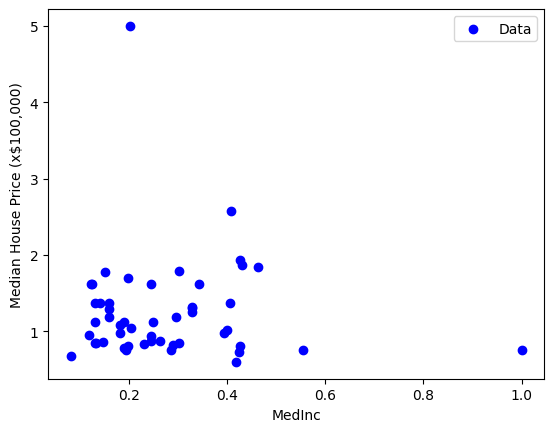

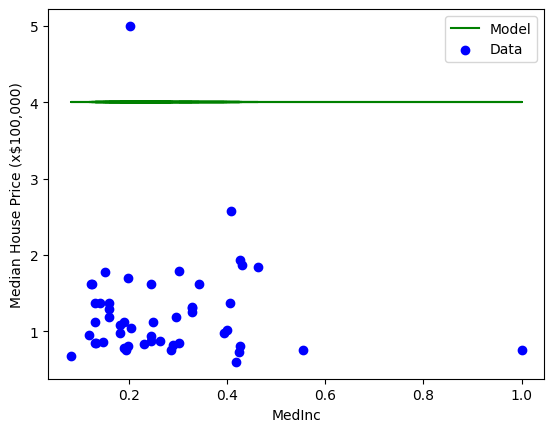

In [7]:
plotmodel(x, y, None)
plotmodel(x, y, np.array([4, 0]))

Initially, let's assume that we don't actually have a bias term. This will make visualizing the parameter space easier. We'll find the best model and plot a few models along the way, specifically, the initial random model and models after traversing each quarter of the search space.

# iterations:  194
first model:  [[0.      ]
 [0.186012]]
best model:  [[0.        ]
 [3.43439646]]
Iteration:  1
Gradient:  [[-1.2017338]
 [-0.3193142]]
Error:  0.9516316872867732


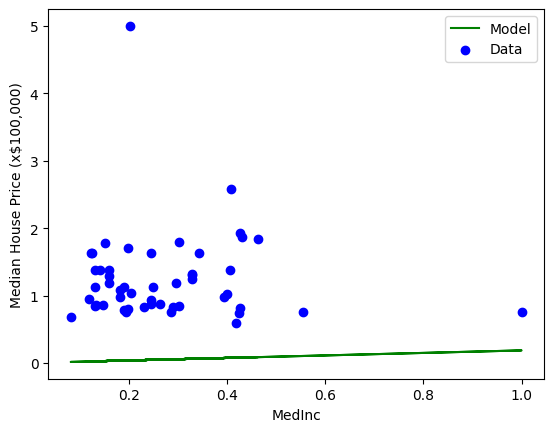

Iteration:  49
Gradient:  [[-0.39245866]
 [-0.02842273]]
Error:  0.4370824622193219


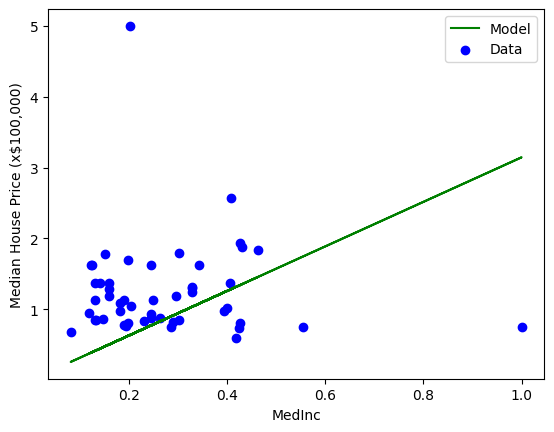

Iteration:  98
Gradient:  [[-0.32007771]
 [-0.00240562]]
Error:  0.4330025158861923


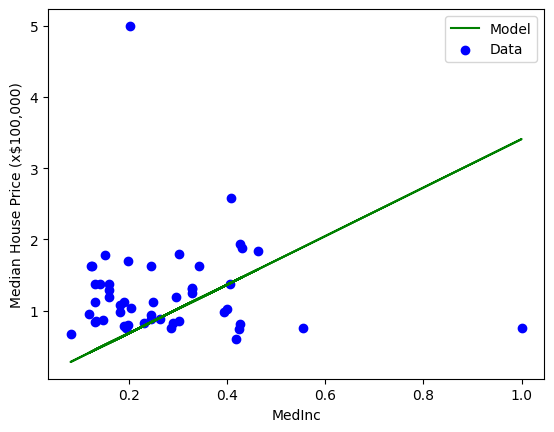

Iteration:  145
Gradient:  [[-3.14011662e-01]
 [-2.25196113e-04]]
Error:  0.4329733365004642


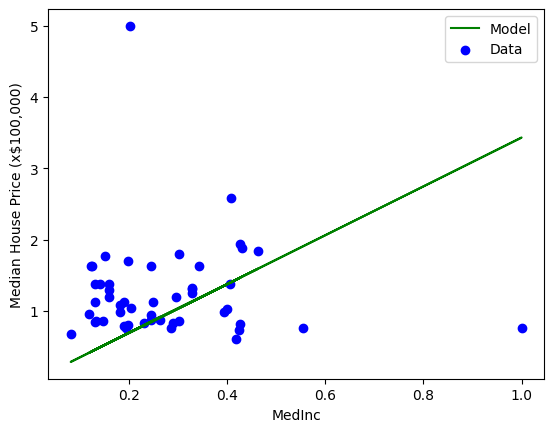

Iteration:  194
Gradient:  [[-3.13438181e-01]
 [-1.90599577e-05]]
Error:  0.43297308037977944


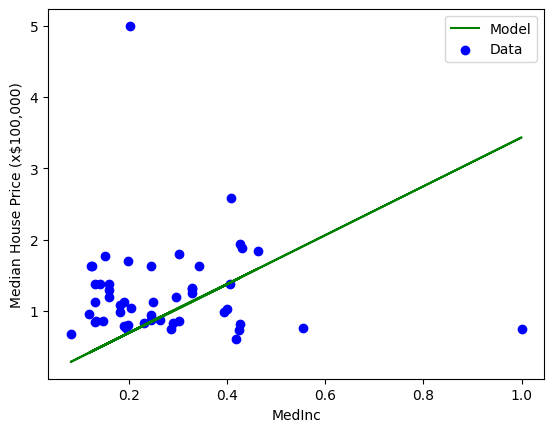

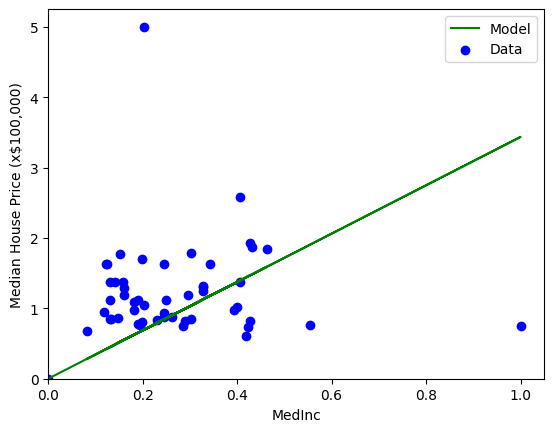

In [8]:
X, t, models, grads, errors = gradient_descent(x, y, nulbias=True)
print("# iterations: ", len(models))
print("first model: ", models[0])
print("best model: ", t)

nits = len(models)
ts = [0, nits//4, nits//2, 3*(nits//4), nits-1] # quartles
for i in ts:
    print("Iteration: ", i+1)
    print("Gradient: ", grads[i])
    print("Error: ", errors[i])
    plotmodel(x, y, models[i])
plotmodel(x, y, models[-1], True)

We can plot the cost function in terms of the $\theta$ value. Note that, as $\theta$ gets closer to the optimum value, the distance traveled decreases, even through the step size $\alpha$ remains constant. After 10 steps, the cost function was only 0.34 away from its optimum value.

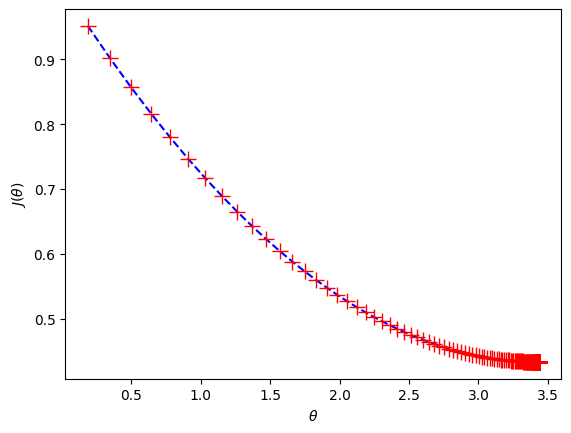

In [9]:
plt.plot([m[1] for m in models], errors, 'b+--', markersize=12, markeredgecolor='r')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.show()

If we also consider the bias term, the optimization takes slightly longer, but is able to fit the evidence much better.

# iterations:  678
first model:  [[2.39898053]
 [1.39992569]]
best model:  [[ 1.30979294]
 [-0.20916258]]
Iteration:  1
Gradient:  [[1.52920073]
 [0.45602525]]
Error:  1.4274027957768818


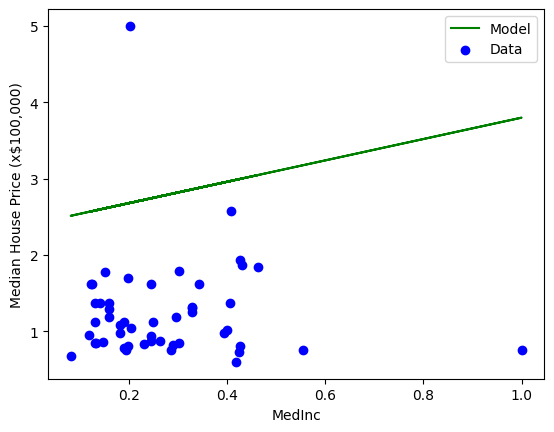

Iteration:  170
Gradient:  [[-0.00115563]
 [ 0.00413366]]
Error:  0.22812862030134512


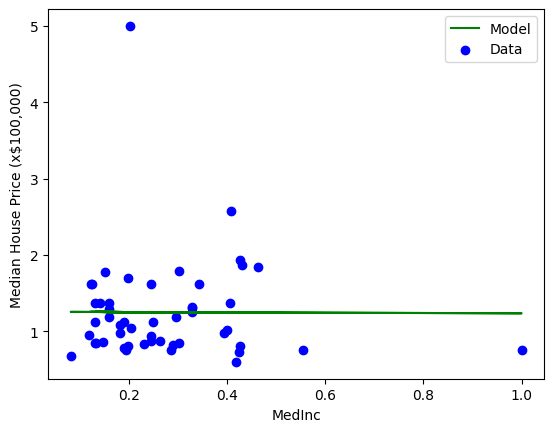

Iteration:  340
Gradient:  [[-0.00017865]
 [ 0.00063901]]
Error:  0.22771701970549033


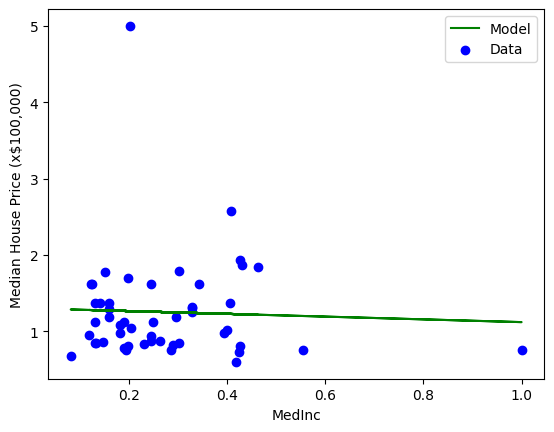

Iteration:  508
Gradient:  [[-2.82297799e-05]
 [ 1.00977666e-04]]
Error:  0.22770719432012357


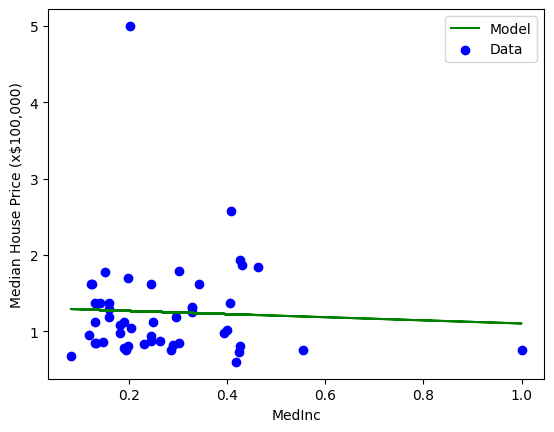

Iteration:  678
Gradient:  [[-4.36398420e-06]
 [ 1.56099317e-05]]
Error:  0.22770694870397118


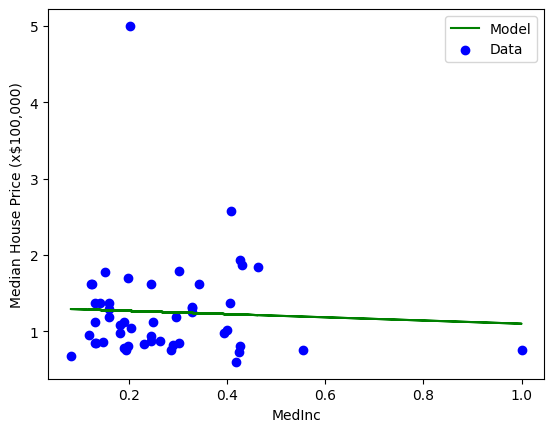

In [10]:
X, t, models, grads, errors = gradient_descent(x, y)
print("# iterations: ", len(models))
print("first model: ", models[0])
print("best model: ", t)

nits = len(models)
ts = [0, nits//4, nits//2, 3*(nits//4), nits-1] # quartles
for i in ts:
    print("Iteration: ", i+1)
    print("Gradient: ", grads[i])
    print("Error: ", errors[i])
    plotmodel(x, y, models[i])

Since $\theta$ is now a vector with two features, we will plot the cost function in 3D space in terms of the two possible values for $\theta$ and the cost function response $J(\theta)$.

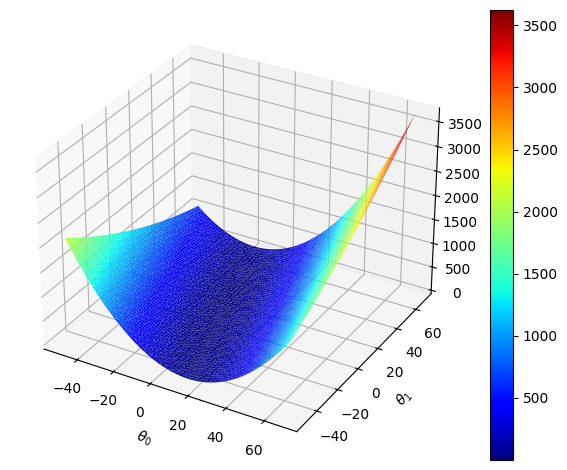

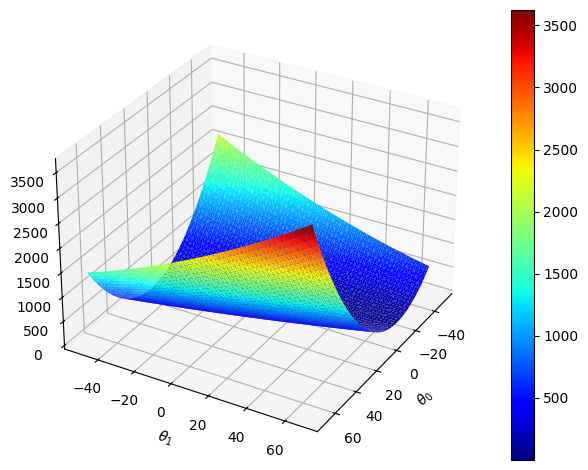

In [11]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plotcost(X, y, start=-100, end=100, step=2, rotate=False):
    """Construct a 3D plot of the cost function range."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    t0s = []
    t1s = []
    errors = []
    for t0 in np.arange(start, end, step):
        for t1 in np.arange(start, end, step):
            t0s.append(t0)
            t1s.append(t1)
            errors.append(compute_cost(np.array([t0, t1]), X, y))
    
    surf = ax.plot_trisurf(t0s, t1s, errors, cmap=cm.jet, linewidth=0.2)
    fig.colorbar(surf)
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')

    if rotate:
        ax.view_init(30, 30)

    fig.tight_layout()
    plt.show()
    
plotcost(X, y, start=-50, end=70)
plotcost(X, y, start=-50, end=70, rotate=True)

## Task: Multi-Variate Linear Regression

Modify the gradient function given to you earlier to perform multivariate linear regression, i.e., the input contains more than one variable. Then, use the function you created to find the combination of any two dependent variables with the least root mean square error with regards to the response/target variable. You do not need to plot the cost function for this exercise.

In [22]:
import time # use time to record function runtime 

# get column names
Index = housing.columns[:-1]

# extract 50 rows
data = housing.loc[51:100].to_numpy()
# normalize the data except for the target
data[:, :-1] = data[:, :-1] / data[:, :-1].max(axis=0)

# get the target
y = data[:,-1].reshape(-1, 1)
results = []

start_time = time.time() # record the start time
for i in range(len(housing.columns)-1):
  x1 = data[:,i]
  for j in range(i+1, len(housing.columns)-1):
    x2 = data[:,j]
    x = np.column_stack((x1, x2)) # use column_stack to make a 2D array, with x1 as the first column and x2 as the second
    _, _, models, _, errors = gradient_descent(x, y, nulbias=True) # note that this forces bias to be 0 - don't try to find a value for it since this makes calculations easier and decreases RMSE
    result = [(housing.columns[i], housing.columns[j]), models[-1], errors[-1]]
    results.append(result)
# get results with the lowest error
results = sorted(results, key=lambda x: x[2])
end_time = time.time() # record the end time

print(f"Best pair of features: {results[0][0][0]}, {results[0][0][1]}")
print("RMSE (Root Mean Squared Error): ", np.sqrt(2*results[0][2])) # calculate RMSE based on error (Half MSE)
print("Half MSE (0.5 * Mean Squared Error): ", results[0][2])
print("Theta 0 (Bias): ", results[0][1][0][0])
print("Theta 1: ", results[0][1][1][0])
print("Theta 2: ", results[0][1][2][0])
print(f"Elasped Time: {end_time - start_time} seconds") # record total time taken for the program to execute

Best pair of features: AveRooms, Longitude
RMSE (Root Mean Squared Error):  0.6166333239637823
Half MSE (0.5 * Mean Squared Error):  0.1901183281113115
Theta 0 (Bias):  0.0
Theta 1:  -1.4352743606899647
Theta 2:  2.071813595593063
Elasped Time: 0.3548734188079834 seconds


Repeat the same exercise using sklearn's linear regression model.

In [21]:
from sklearn.linear_model import LinearRegression

results2 = []
model = LinearRegression(fit_intercept=False) # force bias to be 0 - don't try to find a value for it since this makes calculations easier and decreases MSE

start_time = time.time() # record the start time
for i in range(len(housing.columns)-1):
  x1 = data[:,i]
  for j in range(i+1, len(housing.columns)-1):
    x2 = data[:,j]
    x = np.column_stack((x1, x2)) # use column_stack to make a 2D array, with x1 as the first column and x2 as the second
    y_flat = y.flatten() # flatten y since .fit in sklearn expects a flat 1D array, not a column vector
    model.fit(x, y_flat) # fit the model according to features in x and target values in y_flat
    y_pred = model.predict(x) # predict values for y
    error = float(0.5 * np.mean((y_pred - y_flat)**2)) # calculate error (half MSE) between predicted and actual y values 
    result1 = [(housing.columns[i], housing.columns[j]), model.intercept_, model.coef_, error]
    results2.append(result1)
# get results with the lowest error
results2 = sorted(results2, key=lambda x: x[3])
end_time = time.time() # record the end time

print(f"Best pair of features: {results2[0][0][0]}, {results2[0][0][1]}")
print("RMSE (Root Mean Squared Error): ", np.sqrt(2*results2[0][3])) # calculate RMSE based on error (Half MSE)
print("Half MSE (0.5 * Mean Squared Error): ", results2[0][3])
print("Theta 0 (Bias): ", results2[0][1])
print("Theta 1: ", results2[0][2][0])
print("Theta 2: ", results2[0][2][1])
print(f"Elapsed Time: {end_time - start_time} seconds") # record total time taken for the program to execute

Best pair of features: AveRooms, Longitude
RMSE (Root Mean Squared Error):  0.6166333177383811
Half MSE (0.5 * Mean Squared Error):  0.19011832427252165
Theta 0 (Bias):  0.0
Theta 1:  -1.4357281718391215
Theta 2:  2.0720801111599534
Elapsed Time: 0.01963496208190918 seconds


Compare the results and discuss your findings.

For the manually calculated multivariate linear regression, the best pair of features that I got were AveRooms and Longitude, with an RMSE of about 0.6166333200 (Half MSE of about 0.190118328). I manually set nulbias to True so that the value for the bias (Theta 0) would be 0 (I was told to do this to minimize the error and improve runtime), and for my Theta 1 value I got about -1.435276 and for Theta 2 I got about 2.071815. My sklearn values were almost exaclty the same as my manually calculated values, as I got AveRooms and Longitude as the best features with an RMSE of 0.6166333177 (Half MSE of 0.190118324) and also manually set the bias (Theta 0) to 0 using fit_intercept=False (for the same reasons as the manual model). For Theta 1 I got -1.435728, and for Theta 2 I got 2.072080. Overall, the highly similar values mean that both the manual method and the sklearn method make highly similar predictions. The only difference is that the sklearn method has an RMSE that is just barely smaller than the manual method, which implies that the sklearn method is slightly more accurate, although this improvement is tiny considering that the RMSE difference occurs on the 7th decimal place for both RMSEs. This is likely because the sklearn library is slightly more optimized for calculations than my manual function, although these optimizations lead to only slight accuracy improvements. The real difference between these functions is in runtime, as my manual function runs for roughly 0.35487 seconds (varies a little bit per execution) as compared to sklearn's 0.01963 seconds (varies a little bit per execution), making sklearn much faster than the manual method since it runs in less than 1/10th of the time. This is probably becaue the sklearn library actually uses C, C++, or other lower-level languages faster than Python for many of their time-consuming functions, as these lowel-level languages have less overhead than python and will thus run much faster for very large computations. Overall, while the sklearn method is slightly more accurate than the manual method (although by just a small margin), there is a much larger difference between the runtimes of these multivariate regression techniques, with sklearn running much faster than the manula method.